In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from glob import glob
import zipfile
from tqdm import tqdm
from tensorflow.keras.utils import Sequence

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled.")


Mixed precision enabled.


In [4]:
# Path to the zip file
zip_path = '/content/crowd_wala_dataset.zip'

# Destination directory where the files will be extracted
extract_to = '/content'

# Create the destination folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to: {extract_to}")

Files extracted to: /content


In [5]:
def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    mat = sio.loadmat(mat_file)
    try:
        points = mat['image_info'][0, 0][0, 0][0]
    except:
        raise ValueError("Check the internal structure of your .mat file.")
    return points

Image: IMG_1.jpg
→ Number of people (points): 234
→ Sum of density map: 210.57



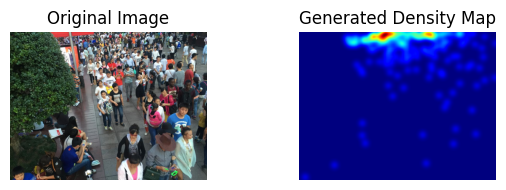

Image: IMG_10.jpg
→ Number of people (points): 230
→ Sum of density map: 207.34



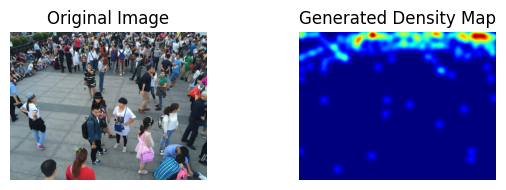

Image: IMG_100.jpg
→ Number of people (points): 206
→ Sum of density map: 203.86



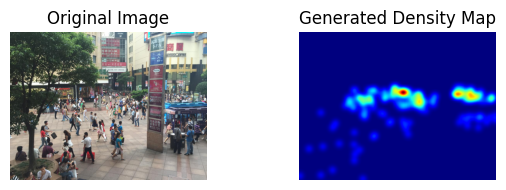

Image: IMG_101.jpg
→ Number of people (points): 83
→ Sum of density map: 80.14



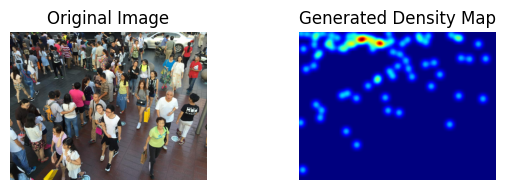

In [6]:
import cv2
image_dir = '/content/crowd_wala_dataset/train_data/images'
mat_dir = '/content/crowd_wala_dataset/train_data/ground_truth'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:4]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mat_path = os.path.join(mat_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

    # Load and resize image (optional)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_shape = img.shape[:2]  # (height, width)

    # Load points and generate density map
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(img_shape, points, sigma=15)

    # Print stats
    print(f"Image: {img_file}")
    print(f"→ Number of people (points): {len(points)}")
    print(f"→ Sum of density map: {density_map.sum():.2f}\n")

    # Show image and density map side by side
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title('Generated Density Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Files extracted to: /content
Image: IMG_1.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 234
→ Sum of density map: 210.57
→ Max density value: 0.0091
→ Density map shape: (768, 1024)



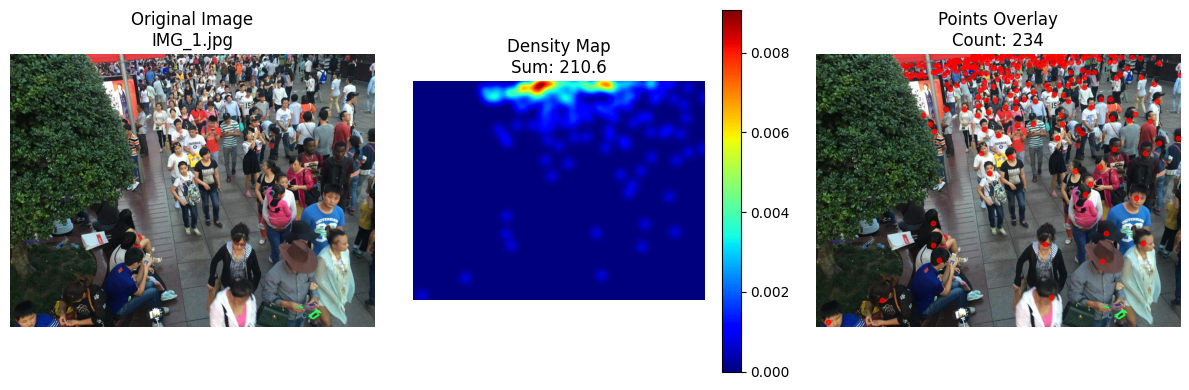

Image: IMG_10.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 230
→ Sum of density map: 207.34
→ Max density value: 0.0052
→ Density map shape: (768, 1024)



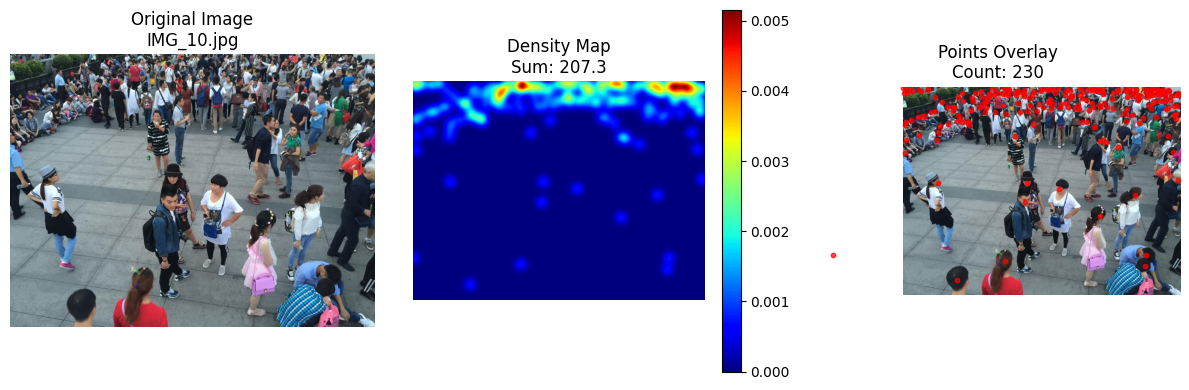

Image: IMG_100.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 206
→ Sum of density map: 203.86
→ Max density value: 0.0078
→ Density map shape: (768, 1024)



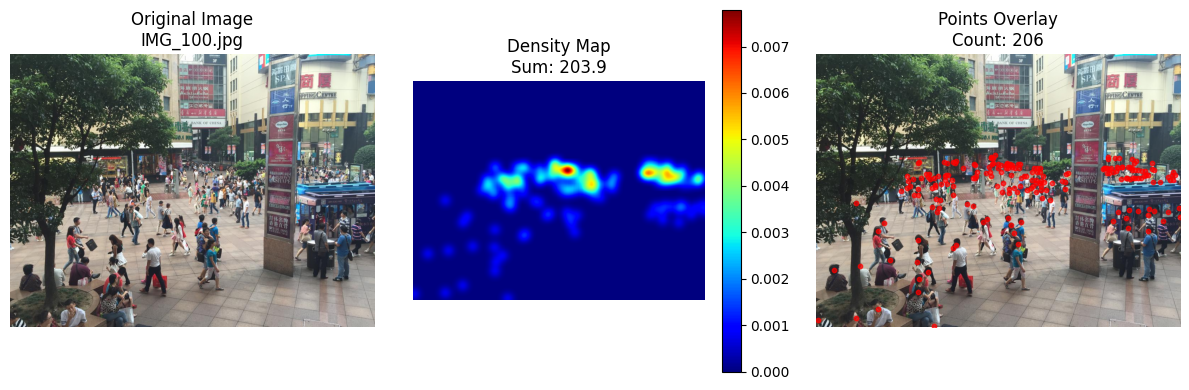

Image: IMG_101.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 83
→ Sum of density map: 80.14
→ Max density value: 0.0024
→ Density map shape: (768, 1024)



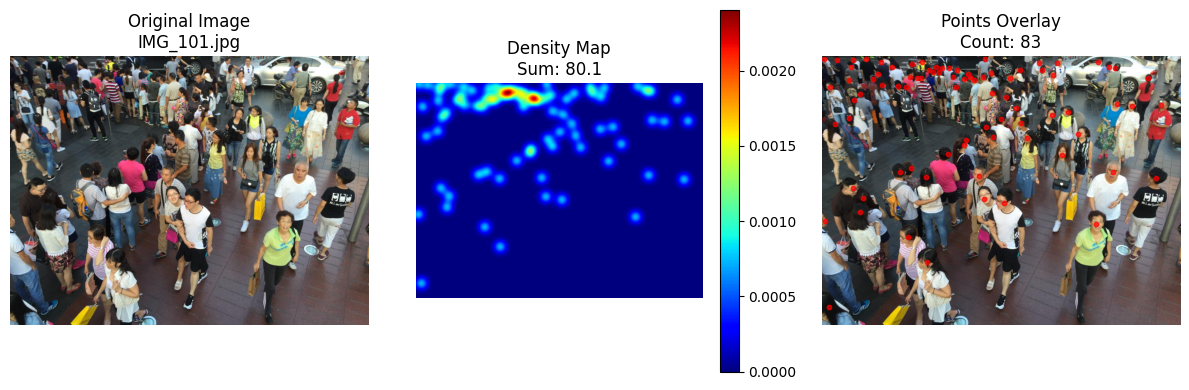

In [7]:
import os
import zipfile
import numpy as np
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt

def extract_dataset(zip_path, extract_to='/content'):
    """Extract dataset with proper error handling"""
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Files extracted to: {extract_to}")
    except zipfile.BadZipFile:
        raise ValueError(f"Invalid zip file: {zip_path}")

def gaussian_kernel_discrete(sigma=15):
    """Generate a discrete Gaussian kernel for density map generation"""
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)  # Normalize to ensure sum = 1
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    """Generate density map from point annotations"""
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        # Handle both (x,y) and (y,x) coordinate systems
        # Assuming points are in (x,y) format where x is horizontal, y is vertical
        x = int(np.clip(point[0], 0, w - 1))
        y = int(np.clip(point[1], 0, h - 1))

        # Calculate bounds for placing kernel
        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        # Calculate corresponding kernel bounds
        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        # Add kernel to density map
        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    """Load annotation points from .mat file with robust error handling"""
    if not os.path.exists(mat_file):
        raise FileNotFoundError(f"Mat file not found: {mat_file}")

    try:
        mat = sio.loadmat(mat_file)

        # Try different possible structures for crowd counting datasets
        possible_keys = ['image_info', 'annPoints', 'points', 'locations']

        for key in possible_keys:
            if key in mat:
                if key == 'image_info':
                    # ShanghaiTech dataset structure
                    try:
                        points = mat[key][0, 0][0, 0][0]
                        break
                    except:
                        continue
                else:
                    # Direct points array
                    points = mat[key]
                    break
        else:
            # If no known key found, print available keys for debugging
            print(f"Available keys in {mat_file}: {list(mat.keys())}")
            raise KeyError("Could not find annotation points in mat file")

        # Ensure points is 2D array with shape (N, 2)
        points = np.array(points)
        if points.ndim == 1 and len(points) == 0:
            return np.empty((0, 2))
        elif points.ndim == 1:
            points = points.reshape(-1, 2)

        return points

    except Exception as e:
        print(f"Error loading {mat_file}: {str(e)}")
        raise

def visualize_density_analysis(image_dir, mat_dir, num_images=4):
    """Main function to analyze and visualize density maps"""

    # Get image files
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mat_dir):
        raise FileNotFoundError(f"Mat directory not found: {mat_dir}")

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    if len(image_files) == 0:
        raise ValueError("No image files found in the directory")

    # Limit number of images to process
    image_files = image_files[:num_images]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)

        # Try different mat file naming conventions
        base_name = os.path.splitext(img_file)[0]
        possible_mat_names = [
            f'GT_{base_name}.mat',
            f'{base_name}_ann.mat',
            f'{base_name}.mat'
        ]

        mat_path = None
        for mat_name in possible_mat_names:
            potential_path = os.path.join(mat_dir, mat_name)
            if os.path.exists(potential_path):
                mat_path = potential_path
                break

        if mat_path is None:
            print(f"⚠️ No corresponding mat file found for {img_file}")
            continue

        try:
            # Load and process image
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not load image: {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_shape = img.shape[:2]  # (height, width)

            # Load points and generate density map
            points = load_points_from_mat(mat_path)
            density_map = generate_density_map(img_shape, points, sigma=15)

            # Print statistics
            print(f"Image: {img_file}")
            print(f"→ Image shape: {img_shape}")
            print(f"→ Number of people (points): {len(points)}")
            print(f"→ Sum of density map: {density_map.sum():.2f}")
            print(f"→ Max density value: {density_map.max():.4f}")
            print(f"→ Density map shape: {density_map.shape}\n")

            # Visualize
            plt.figure(figsize=(12, 4))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f'Original Image\n{img_file}')
            plt.axis('off')

            # Density map
            plt.subplot(1, 3, 2)
            plt.imshow(density_map, cmap='jet')
            plt.title(f'Density Map\nSum: {density_map.sum():.1f}')
            plt.colorbar()
            plt.axis('off')

            # Overlay points on image
            plt.subplot(1, 3, 3)
            plt.imshow(img)
            if len(points) > 0:
                plt.scatter(points[:, 0], points[:, 1], c='red', s=10, alpha=0.7)
            plt.title(f'Points Overlay\nCount: {len(points)}')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"❌ Error processing {img_file}: {str(e)}")
            continue

# Main execution
if __name__ == "__main__":
    # Configuration
    zip_path = '/content/crowd_wala_dataset.zip'
    extract_to = '/content'

    # Extract dataset
    try:
        extract_dataset(zip_path, extract_to)
    except Exception as e:
        print(f"❌ Extraction failed: {str(e)}")
        exit(1)

    # Set paths
    image_dir = '/content/crowd_wala_dataset/train_data/images'
    mat_dir = '/content/crowd_wala_dataset/train_data/ground_truth'

    # Run analysis
    try:
        visualize_density_analysis(image_dir, mat_dir, num_images=4)
    except Exception as e:
        print(f"❌ Analysis failed: {str(e)}")

In [8]:
# === Apply to all .mat files ===
input_dir = '/content/crowd_wala_dataset/train_data/ground_truth'
output_dir = '/content/ground_truth_density_map'
os.makedirs(output_dir, exist_ok=True)

# Use your actual image shape here (height, width)
image_shape = (768, 1024)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Generating density maps"):
    mat_path = os.path.join(input_dir, file)
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(image_shape, points, sigma=15)

    # Save the density map as a .npy file
    output_path = os.path.join(output_dir, file.replace('.mat', '.npy'))
    np.save(output_path, density_map)

Generating density maps: 100%|██████████| 400/400 [00:05<00:00, 69.61it/s]


In [9]:
class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(224, 224), batch_size=16, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = (1024, 768)
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get sorted image filenames
        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            # Load image
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
            img = img.astype(np.float32)

            # Load corresponding density map
            density_fname = 'GT_' + fname.replace('.jpg', '.npy')
            density_path = os.path.join(self.density_dir, density_fname)
            density_map = np.load(density_path)

            # ✅ Resize density map to match model output size (e.g. 28x28)
            original_sum = density_map.sum()
            density_map = cv2.resize(density_map, (1024, 768), interpolation=cv2.INTER_CUBIC)
            density_map *= (original_sum / density_map.sum() + 1e-6)  # normalization
            density_map = density_map[..., np.newaxis]

            batch_images.append(img)
            batch_density_maps.append(density_map)

        return np.array(batch_images), np.array(batch_density_maps)

In [10]:
# ----------------------------------------
# Load Data Generator
# ----------------------------------------

# Assume your generator is named ImageDensityMapGenerator and you defined it earlier
train_gen = ImageDensityMapGenerator(
    image_dir='/content/crowd_wala_dataset/train_data/images',
    density_dir='/content/ground_truth_density_map',
    image_size=(224, 224),
    batch_size=16,
    shuffle=True)
# ----------------------------------------
# Split into Train/Val
# ----------------------------------------

# Take 90% training, 10% validation
total_size = len(train_gen.image_filenames)
train_size = int(0.9 * total_size)
val_filenames = train_gen.image_filenames[train_size:]
train_filenames = train_gen.image_filenames[:train_size]

train_gen.image_filenames = train_filenames
val_gen = ImageDensityMapGenerator(
    image_dir=train_gen.image_dir,
    density_dir=train_gen.density_dir,
    image_size=train_gen.image_size,
    batch_size=train_gen.batch_size,
    shuffle=False)

val_gen.image_filenames = val_filenames


In [11]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class CrowdDataset(Dataset):
    def __init__(self, image_dir, density_dir, transform=None):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        density_path = os.path.join(self.density_dir, "GT_" + img_name.replace('.jpg', '.npy'))

        image = Image.open(img_path).convert('RGB')
        density = np.load(density_path)
        density = torch.from_numpy(density).unsqueeze(0).float()

        if self.transform:
            image = self.transform(image)
        return image, density


In [12]:
transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CrowdDataset('/content/crowd_wala_dataset/train_data/images', '/content/ground_truth_density_map', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)


In [13]:
import timm
import torch.nn as nn

class ViTCrowdRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('vit_base_patch16_384', pretrained=True)
        self.backbone.head = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        count = self.regressor(features)
        return count.squeeze(1)


In [19]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTCrowdRegressor().to(device) # Define model here
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# for epoch in range(10):
#     model.train()
#     running_loss = 0.0
#     for images, density_maps in train_loader:
#         images = images.to(device)
#         gt_counts = density_maps.sum(dim=[1,2,3]).to(device)
#         optimizer.zero_grad()
#         pred_counts = model(images)
#         loss = criterion(pred_counts, gt_counts)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * images.size(0)
#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader.dataset):.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, ExponentialLR
import os

# Assume val_loader is defined from previous steps:
# from torch.utils.data import DataLoader
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

# Device configuration (already in your snippet)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, Optimizer, Criterion (already in your snippet)
# model = ViTCrowdRegressor().to(device) # Assuming ViTCrowdRegressor is defined
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss() # Your chosen loss function

# --- Learning Rate Scheduler Configuration ---
# Choose one of the following schedulers:

# Option 1: StepLR - Decays learning rate by gamma every step_size epochs
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# Option 2: ReduceLROnPlateau - Reduces LR when validation loss plateaus
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Option 3: CosineAnnealingLR - Cosine annealing schedule
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Option 4: ExponentialLR - Exponential decay
# scheduler = ExponentialLR(optimizer, gamma=0.95)

# Option 5: Custom Multi-Step LR
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 80], gamma=0.1)

# --- Early Stopping and Model Saving Parameters ---
best_val_loss = float('inf') # Initialize with a very high value
patience = 10               # Number of epochs to wait for improvement
patience_counter = 0        # Counter for patience
model_save_path = 'best_model.pth' # Path to save the best model

# Create a directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
model_save_path = os.path.join('models', model_save_path)

# Lists to store training history
train_losses = []
val_losses = []
learning_rates = []

# --- Training Loop with Learning Rate Scheduling ---
epochs = 100 # Increased epochs to allow early stopping to work

# Initialize optimizer and scheduler outside the loop
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print(f"Starting training with initial learning rate: {optimizer.param_groups[0]['lr']:.6f}")
print(f"Using scheduler: {type(scheduler).__name__}")

for epoch in range(epochs):
    # Store current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # --- Training Phase ---
    model.train() # Set model to training mode
    running_loss = 0.0
    for images, density_maps in train_loader:
        images = images.to(device)
        # Assuming density_maps are your target for crowd counting, and you sum them for a count.
        # If your model predicts density maps, then density_maps.sum() might not be the direct target.
        # Please ensure gt_counts aligns with your model's output (e.g., if model outputs a single count).
        # If your model outputs density maps, you might need to adjust criterion or process target.
        # For a regressor outputting a single count:
        gt_counts = density_maps.sum(dim=[1,2,3]).to(device) # Summing over H, W, and potentially channels if density_maps are 4D [B, C, H, W]

        optimizer.zero_grad() # Zero the parameter gradients

        pred_counts = model(images)
        # Ensure pred_counts and gt_counts have compatible shapes
        # For regression, pred_counts might be (batch_size, 1) and gt_counts (batch_size).
        pred_counts = pred_counts.squeeze() # Remove dimensions of size 1

        loss = criterion(pred_counts, gt_counts.float()) # Ensure target is float
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, density_maps in val_loader:
            images = images.to(device)
            gt_counts = density_maps.sum(dim=[1,2,3]).to(device)

            pred_counts = model(images)
            pred_counts = pred_counts.squeeze()

            loss = criterion(pred_counts, gt_counts.float())
            val_loss += loss.item() * images.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print training progress with learning rate
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, LR: {current_lr:.6f}")

    # --- Learning Rate Scheduler Step ---
    # The scheduler step placement depends on the scheduler type:

    if isinstance(scheduler, ReduceLROnPlateau):
        # ReduceLROnPlateau needs the validation loss
        scheduler.step(epoch_val_loss)
    else:
        # Other schedulers (StepLR, CosineAnnealingLR, ExponentialLR, etc.)
        scheduler.step()

    # --- Early Stopping and Best Model Saving Logic ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0 # Reset patience since improvement was observed
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'learning_rates': learning_rates
        }, model_save_path)
        print(f"Validation loss improved. Saving model to {model_save_path}")
    else:
        patience_counter += 1 # Increment patience counter
        print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} epochs.")
            break # Exit the training loop

print("\nTraining finished!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

# Optional: Load the best model weights after training
# checkpoint = torch.load(model_save_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# print(f"Best model loaded from {model_save_path}")

# Optional: Plot training curves
import matplotlib.pyplot as plt

def plot_training_curves():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot learning rate
    ax2.plot(learning_rates, label='Learning Rate', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.legend()
    ax2.grid(True)
    ax2.set_yscale('log')  # Log scale for better visualization

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Uncomment to plot training curves
# plot_training_curves()

# Add evaluation after the training loop
# evaluate(model, val_loader) # Moved to cell TZpacz8TSLMr

Starting training with initial learning rate: 0.000100
Using scheduler: ReduceLROnPlateau


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/100, Train Loss: 14451.7511, Val Loss: 13717.9478, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth
Epoch 2/100, Train Loss: 9478.1111, Val Loss: 9816.8024, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/100, Train Loss: 8055.8896, Val Loss: 8885.6918, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/100, Train Loss: 7846.1508, Val Loss: 8921.8251, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/100, Train Loss: 7798.6254, Val Loss: 8556.7046, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth
Epoch 6/100, Train Loss: 7824.4173, Val Loss: 7926.4887, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/100, Train Loss: 6034.5917, Val Loss: 8502.9780, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/100, Train Loss: 6900.5178, Val Loss: 6907.3440, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/100, Train Loss: 4874.4829, Val Loss: 8212.8269, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/100, Train Loss: 4602.1973, Val Loss: 9474.1887, LR: 0.000100
Validation loss did not improve. Patience: 2/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/100, Train Loss: 3411.6165, Val Loss: 6331.3028, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/100, Train Loss: 2566.3975, Val Loss: 5409.6652, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/100, Train Loss: 3564.3159, Val Loss: 9041.8588, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/100, Train Loss: 2942.2745, Val Loss: 4813.3496, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/100, Train Loss: 1976.5133, Val Loss: 4889.2043, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/100, Train Loss: 1495.9112, Val Loss: 4669.1596, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/100, Train Loss: 1276.9654, Val Loss: 4223.6840, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/100, Train Loss: 1137.8873, Val Loss: 3806.8001, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/100, Train Loss: 1022.3430, Val Loss: 3432.5649, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/100, Train Loss: 751.8300, Val Loss: 3572.5573, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21/100, Train Loss: 808.2317, Val Loss: 3333.0621, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22/100, Train Loss: 763.0725, Val Loss: 4194.6730, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23/100, Train Loss: 646.9015, Val Loss: 3589.2616, LR: 0.000100
Validation loss did not improve. Patience: 2/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24/100, Train Loss: 633.2107, Val Loss: 3506.3207, LR: 0.000100
Validation loss did not improve. Patience: 3/10
Epoch 25/100, Train Loss: 660.4564, Val Loss: 3675.5394, LR: 0.000100
Validation loss did not improve. Patience: 4/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26/100, Train Loss: 523.3474, Val Loss: 3134.0219, LR: 0.000100
Validation loss improved. Saving model to models/best_model.pth


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27/100, Train Loss: 623.6290, Val Loss: 3768.1036, LR: 0.000100
Validation loss did not improve. Patience: 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28/100, Train Loss: 640.5041, Val Loss: 4017.0272, LR: 0.000100
Validation loss did not improve. Patience: 2/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29/100, Train Loss: 480.1559, Val Loss: 3485.3179, LR: 0.000100
Validation loss did not improve. Patience: 3/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30/100, Train Loss: 493.4090, Val Loss: 3524.0231, LR: 0.000100
Validation loss did not improve. Patience: 4/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31/100, Train Loss: 471.0314, Val Loss: 3299.1744, LR: 0.000100
Validation loss did not improve. Patience: 5/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32/100, Train Loss: 508.9794, Val Loss: 4066.6367, LR: 0.000100
Validation loss did not improve. Patience: 6/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33/100, Train Loss: 492.1219, Val Loss: 3440.3065, LR: 0.000050
Validation loss did not improve. Patience: 7/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34/100, Train Loss: 327.2924, Val Loss: 3618.2410, LR: 0.000050
Validation loss did not improve. Patience: 8/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35/100, Train Loss: 379.3257, Val Loss: 3452.5194, LR: 0.000050
Validation loss did not improve. Patience: 9/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36/100, Train Loss: 325.1432, Val Loss: 3205.6595, LR: 0.000050
Validation loss did not improve. Patience: 10/10
Early stopping triggered after 36 epochs due to no improvement in validation loss for 10 epochs.

Training finished!
Best validation loss: 3134.0219
Final learning rate: 0.000050


NameError: name 'evaluate' is not defined

In [21]:
from torch.utils.data import DataLoader

# Use the val_dataset created in the previous cell
val_loader = DataLoader(
    val_dataset, # Use val_dataset instead of val_gen
    batch_size=8,      # Use same batch size as above
    shuffle=False,     # Do not shuffle for validation
    num_workers=4      # Adjust based on your CPU
)
def evaluate(model, val_loader):
    model.eval()
    mae = 0.0
    mse = 0.0
    with torch.no_grad():
        for images, density_maps in val_loader:
            images = images.to(device)
            gt_counts = density_maps.sum(dim=[1,2,3]).to(device)
            pred_counts = model(images)
            mae += (pred_counts - gt_counts).abs().sum().item()
            mse += ((pred_counts - gt_counts) ** 2).sum().item()
    mae /= len(val_loader.dataset)
    mse = (mse / len(val_loader.dataset)) ** 0.5
    print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")
evaluate(model,val_loader)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


MAE: 38.90, RMSE: 56.62
